2022-04-21 10:10:36.885500: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-21 10:10:36.885857: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-21 10:10:36.887249: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

2022-04-21 10:10:38.813405: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-21 10:10:38.832619: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 10s 76ms/step - loss: 0.4734 - accuracy: 0.7662 - val_loss: 0.3037 - val_accuracy: 0.8660
Epoch 2/30
100/100 [==============================] - 4s 39ms/step - loss: 0.2477 - accuracy: 0.9052 - val_loss: 0.2533 - val_accuracy: 0.8930
Epoch 3/30
100/100 [==============================] - 3s 33ms/step - loss: 0.1721 - accuracy: 0.9394 - val_loss: 0.2404 - val_accuracy: 0.9010
Epoch 4/30
100/100 [==============================] - 4s 44ms/step - loss: 0.1140 - accuracy: 0.9670 - val_loss: 0.2837 - val_accuracy: 0.8850
Epoch 5/30
100/100 [==============================] - 4s 37ms/step - loss: 0.1122 - accuracy: 0.9628 - val_loss: 0.2424 - val_accuracy: 0.8980
Epoch 6/30
100/100 [==============================] - 3s 31ms/step - loss: 0.0781 - accuracy: 0.9821 - val_loss: 0.2500 - val_accuracy: 0.8910
Epoch 7/30
100/100 [==============================] - 3s 

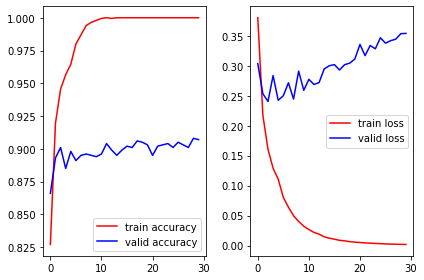

In [1]:
### Transfer Learning

# Keras는 전이학습을 위해서 VGG16을 제공해줌
from tensorflow.keras.applications import VGG16

model_base = VGG16(weights='imagenet',
                   include_top=False,             
                   input_shape=(150,150,3))

print(model_base.summary())

## 우리가 가지고 있는 데이터(개와 고양이)를 VGG16에 통과시켜서
## 이미지의 특징을 ndarray형태로 저장!

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '../data/cat_dog_small/'
train_dir = os.path.join(base_dir, 'train')  #../data/cat_dog_small/train
valid_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1/255)

def extraction_feature(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count,))
    
    generator = datagen.flow_from_directory(
        directory,
        classes=['cats','dogs'],
        target_size=(150,150),
        batch_size=20,
        class_mode='binary'
    )
    
    i=0
    
    for x_data_batch, t_data_batch in generator:
        feature_batch = model_base.predict(x_data_batch)  # 20개 이미지 특성추출
        features[i*20:(i+1)*20] = feature_batch
        labels[i*20:(i+1)*20] = t_data_batch
        
        i = i+1
        if i*20 >= sample_count:
            break
            
    return features, labels
        
    
train_features, train_labels = extraction_feature(train_dir, 2000)
valid_features, valid_labels = extraction_feature(valid_dir, 1000)
test_features, test_labels = extraction_feature(test_dir, 1000)


## 이 ndarray를 이용해서 DNN 학습

train_x_data = np.reshape(train_features,(2000, 4*4*512))  # 2차원
train_t_data = train_labels

valid_x_data = np.reshape(valid_features,(1000, 4*4*512))  # 2차원
valid_t_data = valid_labels

test_x_data = np.reshape(test_features,(1000, 4*4*512))  # 2차원
test_t_data = test_labels


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Flatten(input_shape=(4*4*512,)))

model.add(Dense(units=256,
                activation='relu'))

model.add(Dropout(rate=0/5))

model.add(Dense(units=1,
               activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_x_data,
                    train_t_data,
                    epochs=30,
                    batch_size=20,
                    validation_data=(valid_x_data, valid_t_data))


####################  그래프 그리기  ####################
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

figure = plt.figure()
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

ax1.plot(train_acc, color='r', label='train accuracy')
ax1.plot(valid_acc, color='b', label='valid accuracy')
ax1.legend()

ax2.plot(train_loss, color='r', label='train loss')
ax2.plot(valid_loss, color='b', label='valid loss')
ax2.legend()

plt.tight_layout()
plt.show()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 454s - loss: 0.6195 - accuracy: 0.6650 - val_loss: 0.3978 - val_accuracy: 0.8330
Epoch 2/30
100/100 - 541s - loss: 0.4980 - accuracy: 0.7615 - val_loss: 0.3497 - val_accuracy: 0.8550
Epoch 3/30
100/100 - 546s - loss: 0.4420 - accuracy: 0.8015 - val_loss: 0.3276 - val_accuracy: 0.8600
Epoch 4/30
100/100 - 544s - loss: 0.4474 - accuracy: 0.7895 - val_loss: 0.3096 - val_accuracy: 0.8630
Epoch 5/30
100/100 - 539s - loss: 0.4075 - accuracy: 0.8060 - val_loss: 0.3290 - val_accuracy: 0.8470
Epoch 6/30
100/100 - 535s - loss: 0.4097 - accuracy: 0.8060 - val_loss: 0.2903 - val_accuracy: 0.8780
Epoch 7/30
100/100 - 534s - loss: 0.4014 - accuracy: 0.8030 - val_loss: 0.3158 - val_accuracy: 0.8560
Epoch 8/30
100/100 - 535s - loss: 0.3846 - accuracy: 0.8285 - val_loss: 0.3598 - val_accuracy: 0.8360
Epoch 9/30
100/100 - 535s - loss: 0.3818 - accuracy: 0.8300 - val_loss: 0.2898 - val_accuracy: 0.864

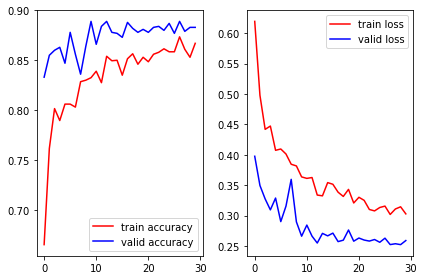

In [9]:
### 이미지 증식을 이용한 전이학습

import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

train_dir = '../data/cat_dog_small/train'
valid_dir = '../data/cat_dog_small/validation'

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

valid_datagen = ImageDataGenerator(rescale=1/255)


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=['cats','dogs'],
                                                    target_size=(150,150),
                                                    batch_size=20,
                                                    class_mode='binary') # binary = 이중분류, categorycal = 다중분류

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    classes=['cats','dogs'],
                                                    target_size=(150,150),
                                                    batch_size=20,
                                                    class_mode='binary') # binary = 이중분류, categorycal = 다중분류


# Pretrained Network
model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))

model_base.trainable = False  # Convolution layer안의 parameter 동결

#print(model_base.summary())


# model 구현
model = Sequential()
model.add(model_base)
model.add(Flatten(input_shape=(4*4*512,)))

model.add(Dense(units=256,
                activation='relu'))

model.add(Dropout(rate=0.5))

model.add(Dense(units=1,
                activation='sigmoid'))

#print(model.summary())

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=valid_generator,
                    validation_steps=50,
                    verbose=2)


model.save('../data/cats_dogs_small/TransferLearning_cnn_cat_dog_small_model.h5')


import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

figure = plt.figure()
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

ax1.plot(train_acc, color='r', label='train accuracy')
ax1.plot(valid_acc, color='b', label='valid accuracy')
ax1.legend()

ax2.plot(train_loss, color='r', label='train loss')
ax2.plot(valid_loss, color='b', label='valid loss')
ax2.legend()

plt.tight_layout()
plt.show()